In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.pyplot as plt
import multiprocessing as mp
import matplotlib.ticker as ticker

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 12})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'ytick.labelsize': 12})
plt.rcParams.update({'legend.fontsize': 12})


In [2]:
def _parallel_mc(iter=1000):
    pool = mp.Pool(4)

    future_res = [pool.apply_async(sample) for _ in range(iter)]
    res = [f.get() for f in future_res]

    return res

In [3]:
def Asian(Nl,l,M,Npl=10**4,X0=100,r=0.05,sig=0.2,K=100,T=1):
    '''
    Calculates payoff for Asian call with geometric brownian motion for underlying. 
    __Inputs__
    l=fine level
    Nl = desired samples of Yl at this level
    T=time period for SDE to be simulated over
    M=coarseness factor
    Npl=default samples per loop to break up Nl into manageable chunks
    X0,r,sig,K,T = params for SDE
    
    __Outputs__
    suml=[dP_l,dP_l**2,sumPf,sum(Pf**2),sumPc,sum(Pc**2),fg]
    dP_l=sum of payoff differences between coarse and fine paths at this level
    Pf=payoffs at fine level
    Pc=payoffs at coarse level
    fg = sum of Pf*Pc
    '''
    num_rem=Nl #Initialise remaining samples for while loop
    suml=np.zeros(7)
       
    Nsteps=M**l #Number of fine steps
    dt=T/Nsteps
    sqrt_dt=np.sqrt(dt)
    while (num_rem>0): #<---Parallelise this while loop
        N_loop=min(Npl,num_rem) #Break up Nl into manageable chunks of size Npl, until last iteration
        num_rem-=N_loop #On final iteration N_loop=num_rem, so num_rem will be=0 and 

        #Initialise fine, coarse asset prices; coarse Brownian increment (BI)
        Xf=X0*np.ones(N_loop)
        Xc=X0*np.ones(N_loop)
        Af=0.5*dt*Xf
        Ac=0.5*M*dt*Xc
        dWc=np.zeros(N_loop)
        for j in range(1,Nsteps+1): #Note that if Nsteps=1 (l=0), j=1 and so coarse path not developed
            dWf=np.random.randn(N_loop)*sqrt_dt
            dWc=dWc+dWf #Keep adding to coarse BI every loop until j is integer multiple of M
            Xf+=r*Xf*dt + sig*Xf*dWf
            Af+=Xf*dt
            if j%M==0: #if j is integer multiple of M...
                Xc+=r*Xc*M*dt + sig*Xc*dWc #...Develop coarse path
                Ac+=Xc*M*dt
                dWc=np.zeros(N_loop) #...Re-initialise coarse BI to 0

        Af-=Xf*dt
        Ac-=Xc*M*dt
        #Calculate payoffs etc.
        Pf=np.maximum(0,Af-K)
        Pf=np.exp(-r*T)*Pf #Payoff at fine level
        sumPf=np.sum(Pf)
        sumPf2=np.sum(Pf**2)
        if l==0:
            suml+=np.array([sumPf,sumPf2,sumPf,sumPf2,0,0,0])
        else:
            Pc=np.maximum(0,Ac-K)
            Pc=np.exp(-r*T)*Pc #Payoff at coarse level
            dP_l=Pf-Pc #Payoff difference
            sumPc=np.sum(Pc)
            sumPc2=np.sum(Pc**2)
            fg=np.sum(Pc*Pf)
            suml+=np.array([np.sum(dP_l),np.sum(dP_l**2),sumPf,sumPf2,sumPc,sumPc2,fg])
            
    return suml

def European(Nl,l,M,Npl=10**4,X0=100,r=0.05,sig=0.2,K=100,T=1):
    '''
    Calculates payoff for European call with geometric brownian motion for underlying. 
    __Inputs__
    l=fine level
    Nl = desired samples of Yl at this level
    T=time period for SDE to be simulated over
    M=coarseness factor
    Npl=default samples per loop to break up Nl into manageable chunks
    X0,r,sig,K,T = params for SDE
    
    __Outputs__
    suml=[dP_l,dP_l**2,sumPf,sum(Pf**2),sumPc,sum(Pc**2),fg]
    dP_l=sum of payoff differences between coarse and fine paths at this level
    Pf=payoffs at fine level
    Pc=payoffs at coarse level
    fg = sum of Pf*Pc
    '''
    num_rem=Nl #Initialise remaining samples for while loop
    suml=np.zeros(7)    
    Nsteps=M**l #Number of fine steps
    dt=T/Nsteps
    sqrt_dt=np.sqrt(dt)
    
    while (num_rem>0): #<---Parallelise this while loop
        N_loop=min(Npl,num_rem) #Break up Nl into manageable chunks of size Npl, until last iteration
        num_rem-=N_loop #On final iteration N_loop=num_rem, so num_rem will be=0 and 
        #Initialise fine, coarse asset prices; coarse Brownian increment (BI)
        Xf=X0*np.ones(N_loop)
        Xc=X0*np.ones(N_loop)
        dWc=np.zeros(N_loop)
        for j in range(1,Nsteps+1): #Note that if Nsteps=1 (l=0), j=1 and so coarse path not developed
            dWf=np.random.randn(N_loop)*sqrt_dt
            dWc=dWc+dWf #Keep adding to coarse BI every loop until j is integer multiple of M
            Xf+=r*Xf*dt + sig*Xf*dWf
            if j%M==0: #if j is integer multiple of M...
                Xc+=r*Xc*M*dt + sig*Xc*dWc #...Develop coarse path
                dWc=np.zeros(N_loop) #...Re-initialise coarse BI to 0

        #Calculate payoffs etc.
        Pf=np.maximum(0,Xf-K)
        Pf=np.exp(-r*T)*Pf #Payoff at fine level
        sumPf=np.sum(Pf)
        sumPf2=np.sum(Pf**2)
        if l==0:
            suml+=np.array([sumPf,sumPf2,sumPf,sumPf2,0,0,0])
        else:
            Pc=np.maximum(0,Xc-K)
            Pc=np.exp(-r*T)*Pc #Payoff at coarse level
            dP_l=Pf-Pc #Payoff difference
            sumPc=np.sum(Pc)
            sumPc2=np.sum(Pc**2)
            fg=np.sum(Pc*Pf)
            suml+=np.array([np.sum(dP_l),np.sum(dP_l**2),sumPf,sumPf2,sumPc,sumPc2,fg])
            
    return suml

def Lookback(Nl,l,M,Npl=10**4,X0=100,r=0.05,sig=0.2,K=100,T=1):
    '''
    Calculates payoff for Lookback call with geometric brownian motion for underlying. 
    __Inputs__
    l=fine level
    Nl = desired samples of Yl at this level
    T=time period for SDE to be simulated over
    M=coarseness factor
    Npl=default samples per loop to break up Nl into manageable chunks
    X0,r,sig,K,T = params for SDE
    
    __Outputs__
    suml=[dP_l,dP_l**2,sumPf,sum(Pf**2),sumPc,sum(Pc**2),fg]
    dP_l=sum of payoff differences between coarse and fine paths at this level
    Pf=payoffs at fine level
    Pc=payoffs at coarse level
    fg = sum of Pf*Pc
    '''
    num_rem=Nl #Initialise remaining samples for while loop
    suml=np.zeros(7)    
    Nsteps=M**l #Number of fine steps
    dt=T/Nsteps
    sqrt_dt=np.sqrt(dt)
    
    while (num_rem>0): #<---Parallelise this while loop
        N_loop=min(Npl,num_rem) #Break up Nl into manageable chunks of size Npl, until last iteration
        num_rem-=N_loop #On final iteration N_loop=num_rem, so num_rem will be=0 and 
        #Initialise fine, coarse asset prices; coarse Brownian increment (BI)
        Xf=X0*np.ones(N_loop)
        Xc=X0*np.ones(N_loop)
        Mf=X0*np.ones(N_loop)
        Mc=X0*np.ones(N_loop)
        dWc=np.zeros(N_loop)
        for j in range(1,Nsteps+1): #Note that if Nsteps=1 (l=0), j=1 and so coarse path not developed
            dWf=np.random.randn(N_loop)*sqrt_dt
            dWc=dWc+dWf #Keep adding to coarse BI every loop until j is integer multiple of M
            Xf+=r*Xf*dt + sig*Xf*dWf
            Mf=np.minimum(Xf,Mf)
            if j%M==0: #if j is integer multiple of M...
                Xc+=r*Xc*M*dt + sig*Xc*dWc #...Develop coarse path
                Mc=np.minimum(Xc,Mc)
                dWc=np.zeros(N_loop) #...Re-initialise coarse BI to 0

        #Calculate payoffs etc.
        beta = 0.5826  #special factor for offset correction
        Pf = Xf - Mf*(1-beta*sig*sqrt_dt)
        Pf=np.exp(-r*T)*Pf #Payoff at fine level
        sumPf=np.sum(Pf)
        sumPf2=np.sum(Pf**2)
        if l==0:
            suml+=np.array([sumPf,sumPf2,sumPf,sumPf2,0,0,0])
        else:
            Pc = Xc - Mc*(1-beta*sig*np.sqrt(M*dt))
            Pc=np.exp(-r*T)*Pc #Payoff at coarse level
            dP_l=Pf-Pc #Payoff difference
            sumPc=np.sum(Pc)
            sumPc2=np.sum(Pc**2)
            fg=np.sum(Pc*Pf)
            suml+=np.array([np.sum(dP_l),np.sum(dP_l**2),sumPf,sumPf2,sumPc,sumPc2,fg])
            
    return suml

def Digital(Nl,l,M,Npl=10**4,X0=100,r=0.05,sig=0.2,K=100,T=1):
    '''
    Calculates payoff for Digital call with geometric brownian motion for underlying. 
    __Inputs__
    l=fine level
    Nl = desired samples of Yl at this level
    T=time period for SDE to be simulated over
    M=coarseness factor
    Npl=default samples per loop to break up Nl into manageable chunks
    X0,r,sig,K,T = params for SDE
    
    __Outputs__
    suml=[dP_l,dP_l**2,sumPf,sum(Pf**2),sumPc,sum(Pc**2),fg]
    dP_l=sum of payoff differences between coarse and fine paths at this level
    Pf=payoffs at fine level
    Pc=payoffs at coarse level
    fg = sum of Pf*Pc
    '''
    num_rem=Nl #Initialise remaining samples for while loop
    suml=np.zeros(7)    
    Nsteps=M**l #Number of fine steps
    dt=T/Nsteps
    sqrt_dt=np.sqrt(dt)
    
    while (num_rem>0): #<---Parallelise this while loop
        N_loop=min(Npl,num_rem) #Break up Nl into manageable chunks of size Npl, until last iteration
        num_rem-=N_loop #On final iteration N_loop=num_rem, so num_rem will be=0 and 
        #Initialise fine, coarse asset prices; coarse Brownian increment (BI)
        Xf=X0*np.ones(N_loop)
        Xc=X0*np.ones(N_loop)
        dWc=np.zeros(N_loop)
        for j in range(1,Nsteps+1): #Note that if Nsteps=1 (l=0), j=1 and so coarse path not developed
            dWf=np.random.randn(N_loop)*sqrt_dt
            dWc=dWc+dWf #Keep adding to coarse BI every loop until j is integer multiple of M
            Xf+=r*Xf*dt + sig*Xf*dWf
            if j%M==0: #if j is integer multiple of M...
                Xc+=r*Xc*M*dt + sig*Xc*dWc #...Develop coarse path
                dWc=np.zeros(N_loop) #...Re-initialise coarse BI to 0

        #Calculate payoffs etc.
        Pf=K*(Xf>K).astype(np.int_)
        Pf=np.exp(-r*T)*Pf #Payoff at fine level
        sumPf=np.sum(Pf)
        sumPf2=np.sum(Pf**2)
        if l==0:
            suml+=np.array([sumPf,sumPf2,sumPf,sumPf2,0,0,0])
        else:
            Pc=K*(Xc>K).astype(np.int_)
            Pc=np.exp(-r*T)*Pc #Payoff at coarse level
            dP_l=Pf-Pc #Payoff difference
            sumPc=np.sum(Pc)
            sumPc2=np.sum(Pc**2)
            fg=np.sum(Pc*Pf)
            suml+=np.array([np.sum(dP_l),np.sum(dP_l**2),sumPf,sumPf2,sumPc,sumPc2,fg])
            
    return suml

In [4]:
def N_opt(V,eps,L,M):
    '''
    This shouldn't change depending on alpha, but will change according to gamma.
    Beta is implicitly included in V, since Vl <= hl**beta.
    '''
    sqrt_h=np.sqrt(M**(np.arange(0,L+1)))
    sqrt_V=np.sqrt(V)
    return np.ceil((2/eps**2)*np.sum(sqrt_V*sqrt_h)*sqrt_V/sqrt_h)
    
def mlmc(payoff,eps,N0=10**3,M=2,**kwargs):
    '''
    Runs MLMC method for given mlmc_fn (e.g. mlmc_gbm) which returns an array of sums at each level: 
    suml=[d_Pl,d_Pl**2,Pl,Pl**2].
    __Inputs__
    mlmc_fn = function to call at a given level
    eps = desired accuracy
    N0 = default number of samples to use when initialising new level
    M=coarseness factor
    
    __Outputs__
    sums = array of sums of payoff differences between coarse and fine paths at each level and
           sum of payoffs at fine level, each column is a level
    N = final number of samples at each level
    '''
    L=2

    V=np.zeros(L+1) #Initialise variance vector of each levels' variance
    N=N0*np.ones(L+1) #Initialise num. samples vector of each levels' num. samples
    dN=N0*np.ones(L+1) #Initialise additional samples for this iteration vector for each level
    sums=np.zeros((7,L+1)) #Initialise sums array, each column is a level

    while (np.sum(dN)>0): #Loop until no additional samples asked for
        for l in range(L+1): 
            num=dN[l]
            if num>0: #If asked for additional samples...
                sums[:,l]+=payoff(int(num),l,M,**kwargs) #Call function which gives sums

        
        N+=dN #Increment samples taken counter for each level        
        V=np.maximum((sums[1,:]/N)-(sums[0,:]/N)**2,0) #Calculate variance based on updated samples
        Nl_new=N_opt(V,eps,L,M) #Estimate optimal number of samples at each level
        dN=np.maximum(0,Nl_new-N) #Number of additional samples
        if sum(dN > 0.01*N) == 0:
            if abs(sums[0,-1])/N[-1]>(M-1)*eps*np.sqrt(0.5):
                L+=1
                #Add extra entries for the new level and estimate sums with N0 samples 
                V=np.concatenate((V,np.zeros(1)), axis=0)
                N=np.concatenate((N,N0*np.ones(1)),axis=0)
                dN=np.concatenate((dN,N0*np.ones(1)),axis=0)
                sums=np.concatenate((sums,np.zeros((7,1))),axis=1)
                sums[:,L]+=payoff(N0,L,M,**kwargs)
    
    return sums,N


In [5]:
def mlmc_variance(mlmc_fn,eps,M=2,T=1,N0=10**3):
    sums,N=mlmc(European,eps,N0,M,T)
    L=len(N)-1
    means_dp=sums[0,:]/N
    means_p=sums[2,:]/N

    V_dp=(sums[1,:]/N)-means_dp**2
    V_p=(sums[3,:]/N)-means_p**2

    cost_mlmc=(N[0]+sum(N[1:]*(M**np.arange(L)+M**np.arange(1,L+1))))*eps**2
    cost_mc=2*sum(V_p*M**np.arange(L+1))
    
    fig,ax=plt.subplots(1,2,figsize=(15,8))
    fig.suptitle(f'European Call with GBM, $\epsilon=${eps}\nM={M}')
    fig.tight_layout(pad=6.0)
    ax[0].plot(range(1,L+1),np.log(V_dp[1:])/np.log(M),'k',range(L+1),np.log(V_p)/np.log(M),'b')
    ax[0].set_xlabel('$l$')
    ax[0].set_ylabel(f'log$_{M}$var')
    ax[0].legend(['$P_{l}-P_{l-1}$','$P_{l}$'])
    ax[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    ax[1].plot(range(1,L+1),np.log(means_dp[1:])/np.log(M),'k',range(L+1),np.log(means_p)/np.log(M),'b')
    ax[1].set_xlabel('$l$')
    ax[1].set_ylabel(f'log$_{M}$mean')
    ax[1].legend(['$P_{l}-P_{l-1}$','$P_{l}$'])
    ax[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.savefig('EuroCallGBM_var')

def mlmc_complexity(mlmc_fn,eps,M=2,T=1,N0=10**3):
    cost_mlmc=[]
    cost_mc=[]
    fig,ax=plt.subplots(1,2,figsize=(15,8))
    fig.suptitle(f'European Call with GBM,\nS(0)=K={X0}')
    for e in eps:
        sums,N=mlmc(mlmc_fn,e,N0,M,T)
        L=len(N)-1
        means_p=sums[2,:]/N
        V_p=(sums[3,:]/N)-means_p**2

        cost_mlmc+=[(N[0]+(1+1/M)*np.sum(N[1:]*(M**np.arange(1,L+1))))*e**2]
        cost_mc+=[2*sum(V_p*M**np.arange(L+1))]
        ax[0].semilogy(range(L+1),N,label=f'{e}')
    
    ax[0].set_xlabel('$l$')
    ax[0].set_ylabel('$N_l$')
    ax[0].legend(title=r'$\epsilon$')
    xa=ax[0].xaxis
    xa.set_major_locator(ticker.MaxNLocator(integer=True))

    ax[1].loglog(eps,cost_mlmc,'k',label=label)
    ax[1].set_xlabel(r'$\epsilon$')
    ax[1].set_ylabel(r'$\epsilon^{2}$cost')
    ax[1].legend(['mlmc','mc'])
    plt.savefig('EuroCallGBM_cost')

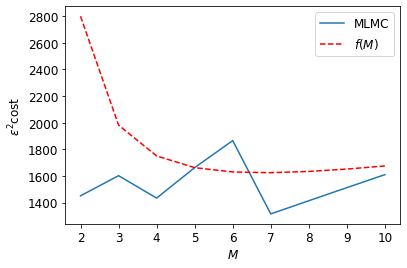

In [6]:
cost_mlmc=[]
cost_mc=[]
for m in [2,3,4,5,6,7,8,9,10]:
    e=0.005
    sums,N=mlmc(European,e,M=m)
    L=len(N)-1
    means_p=sums[2,:]/N
    V_p=(sums[3,:]/N)-means_p**2

    cost_mlmc+=[(N[0]+(1+1/m)*np.sum(N[1:]*(m**np.arange(1,L+1))))*e**2]
    cost_mc+=[2*sum(V_p*m**np.arange(L+1))]

M=np.array([2,3,4,5,6,7,8,9,10])
plt.plot(M,cost_mlmc,label='MLMC')
sc=cost_mlmc[3]/((M[3]-1/M[3])/(np.log(M[3]))**2)
plt.plot(M,sc*(M-1/M)/(np.log(M))**2,'r--',label='$f(M)$')
plt.legend()
plt.ylabel('$\epsilon^{2}$cost')
plt.xlabel('$M$');
plt.savefig('Comparison_Cost_fofM')

In [11]:
#### Exact result according to BS formula
X0=100
r=0.05
sig=0.2
K=100
T=1
D1 =(np.log(X0/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
D2 = D1 - sig*np.sqrt(T)
BS=X0*norm.cdf(D1)-K*np.exp(-r*T)*norm.cdf(D2)
BS

10.450583572185565

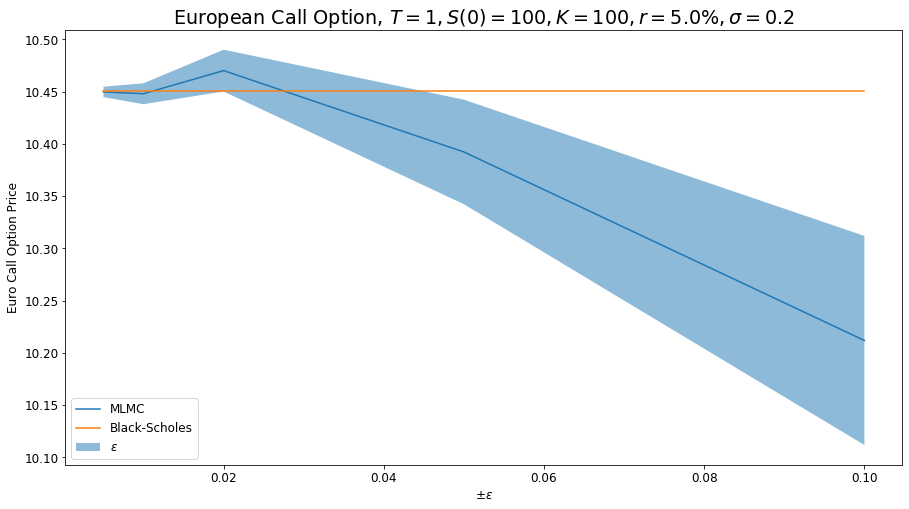

In [13]:
plt.figure(figsize=(15,8))
p=[]
eps=np.array([0.005,0.01,0.02,0.05,0.1])
for e in eps:
        sums,N=mlmc(European,e,M=4)
        p+=[np.sum(sums[0,:]/N)]
plt.plot(eps,p,label='MLMC')
plt.fill_between(eps, p+eps, p-eps, alpha=.5, label='$\pm\epsilon$')
plt.plot(eps,BS*np.ones(len(eps)),label='Black-Scholes')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('Euro Call Option Price')
plt.title(f'European Call Option, $T={T}, S(0)={X0}, K={K}, r={r*100}\%, \sigma={sig}$');

C:\Users\s1505582\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


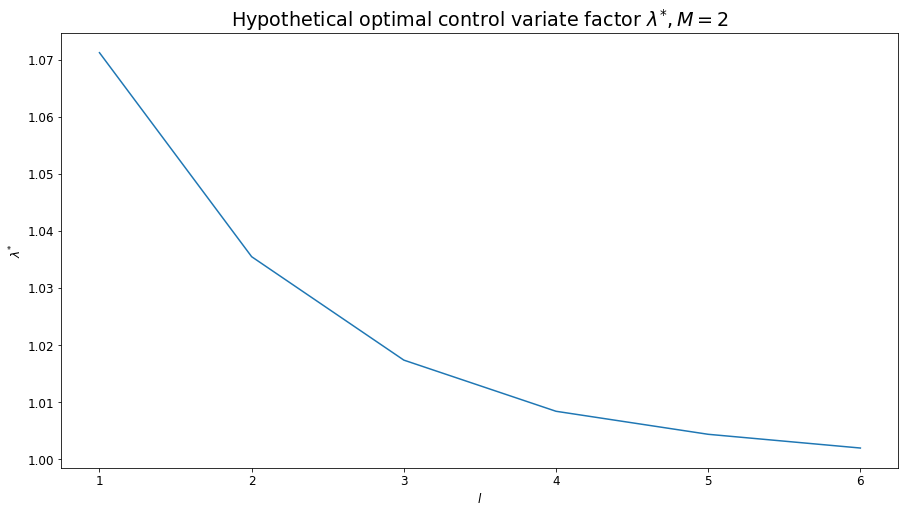

In [6]:
plt.figure(figsize=(15,8))
p=[]
sums,N=mlmc(European,0.005,M=2)
Vg=sums[5,:]/N-(sums[4,:]/N)**2
lam=((sums[6,:]/N)-(sums[2,:]/N)*(sums[4,:]/N))/Vg
plt.plot(range(len(N)),lam)
plt.xlabel('$l$')
plt.ylabel('$\lambda^{*}$')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.title('EuroCall:Hypothetical optimal control variate factor $\lambda^{*}, M=2$');